# Kyle Calabro
# DATA 750 - Thesis in Data Science
# 12 August 2021
---

# Notebook Four:
---
## Implementing State-of-the-Art Techniques (Convolutional Neural Network with Augmented Data)

In [1]:
import librosa
import librosa.display

%matplotlib inline
import matplotlib.pyplot as plt 
from matplotlib.pyplot import specgram

import seaborn as sns

import IPython.display as ipd
from IPython.display import Audio

import seaborn as sns

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os
import sys
import warnings

import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# To ignore deprecation warnings...
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category = DeprecationWarning)

np.random.seed(42)
tf.random.set_random_seed(42)

# Utility Functions
---

In [2]:
# To plot the accuracy of a CNN across epochs

def plot_accuracy(model_hist, model_title):
    plt.plot(model_hist.history["acc"])
    plt.plot(model_hist.history["val_acc"])
    plt.plot(figsize = (16, 16))
    plt.grid(True)
    plt.title(model_title)
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Test"], loc = "best")
    plt.show();

In [3]:
# To plot the loss of a CNN across epochs

def plot_loss(model_hist, model_title):
    plt.plot(model_hist.history["loss"])
    plt.plot(model_hist.history["val_loss"])
    plt.plot(figsize = (16, 16))
    plt.grid(True)
    plt.title(model_title)
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(['Train', 'Test'], loc = "best")
    plt.show();

In [1]:
# To get the predicted labels of a given CNN model
# Params:
    # X_test: features from the test set data
    # model: the CNN model to make predictions with
    # encoder: The label encoder object used to encode labels initially

def get_predictions(X_test, model, encoder):
    y_pred = model.predict(X_test)
    y_pred = y_pred.argmax(axis = 1)
    y_pred = y_pred.astype(int).flatten()
    y_pred = encoder.inverse_transform(y_pred)
    return y_pred

In [5]:
# To get the actual labels of a given CNN model
# Params:
    # y_test: target variable from the test set
    # encoder: The label encoder object used to encode labels initially

def get_labels(y_test, encoder):
    labels = y_test.argmax(axis = 1)
    labels = labels.astype(int).flatten()
    labels = encoder.inverse_transform(labels)
    return labels

In [6]:
# To print a classification report based on predictions from a CNN 
# and provided actual labels
# Params:
    # labels: The actual labels of the target variable
    # y_pred: The predicted labels of the target variable
    # encoder: The label encoder object used to encode labels initially
    
def get_report(labels, y_pred, encoder):
    target_names = encoder.classes_
    print(classification_report(labels, y_pred, target_names))

# Bringing in the Data
----
## Combine original, unaugmented data and augmented data to create a full data set

In [7]:
# Original and augmented training data
aug_train_df = pd.read_csv("aug_train_data.csv", index_col = 0)

In [8]:
aug_train_df.head()

,Augmentation,Gender,Emotion,Actor,0,1,2,3,4,5,...,249,250,251,252,253,254,255,256,257,258
0,Noise,male,Disgust,13,-50.270992,-49.346694,-49.822502,-49.815537,-49.560946,-49.379482,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Noise,female,Disgust,4,-39.650554,-39.008667,-39.701375,-39.664439,-39.599220,-39.127860,...,-38.561129,-38.783143,-38.862264,-39.299520,-39.424192,-39.217359,-39.518335,-39.640597,-38.951977,-39.540231
2,Noise,male,Angry,3,-37.205282,-36.097928,-36.015853,-36.027088,-36.490545,-36.713721,...,-36.593853,-36.322970,-35.913771,-36.037244,-36.094914,-35.603011,-35.208251,-35.657458,-36.039433,-37.443102
3,Noise,male,Angry,5,-46.433297,-45.146911,-45.193402,-45.591403,-44.953065,-45.059758,...,-35.525361,-36.909646,-38.427723,-39.670590,-40.742221,-42.371991,-42.823021,-42.016366,-41.280996,-42.799487
4,Noise,male,Fear,15,-30.231743,-28.766333,-28.951214,-29.360286,-29.361902,-29.129311,...,-29.686859,-29.133970,-29.522443,-29.996766,-29.805341,-29.437936,-29.308242,0.000000,0.000000,0.000000


In [9]:
# Original, unaugmented test data
test_data_df = pd.read_csv("test_data.csv", index_col = 0)

In [10]:
test_data_df.head()

,Augmentation,Gender,Emotion,Actor,0,1,2,3,4,5,...,249,250,251,252,253,254,255,256,257,258
0,None,female,Disgust,22,-64.659958,-65.254463,-66.209488,-66.757156,-66.907104,-67.085808,...,-64.083252,-63.757996,-65.370758,-65.988335,-66.497498,-66.078773,-65.966904,-65.928604,-66.375893,-66.582321
1,None,female,Disgust,12,-65.755157,-65.917175,-62.268135,-58.150547,-57.628590,-58.806004,...,-66.896553,-67.250404,-66.518509,-66.455315,-66.692474,-66.987755,-67.144867,-67.101929,-67.145737,-66.991982
2,None,female,Neutral,20,-78.726570,-78.726570,-78.726570,-78.726570,-78.726570,-78.726570,...,-78.702095,-78.498978,-78.258232,-78.643265,-78.667511,-78.590645,-78.600418,-78.600021,-78.726570,-78.690475
3,None,male,Happy,13,-71.123444,-71.067574,-71.013062,-71.145126,-71.114044,-70.856827,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,None,female,Sad,12,-59.659962,-59.712753,-59.650646,-59.643253,-59.679802,-59.718342,...,-58.745468,-58.556488,-58.488426,-58.246189,-57.929283,-57.702774,-57.935329,-58.349113,-57.699528,-56.257050


# Seperate the Features and the Labels within the Data
---

In [11]:
X_train = aug_train_df.iloc[:, 4:]
y_train = aug_train_df.iloc[:, :3].drop(columns = ["Gender", "Augmentation"])

X_test = test_data_df.iloc[:, 4:]
y_test = test_data_df.iloc[:, :3].drop(columns = ["Gender", "Augmentation"])

In [12]:
print("Training Set Size:", X_train.shape)
print("Test Set Size:", X_test.shape)

Training Set Size: (9216, 259)
Test Set Size: (288, 259)


# Standardizing the data and one-hot encoding the target variable to prepare for CNN deployment
---

In [13]:
# Standardize the data
X_mean = np.mean(X_train, axis = 0)
X_std = np.std(X_train, axis = 0)
X_train = (X_train - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

In [14]:
# Converting data to arrays for use in Tensorflow/Keras
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [15]:
# One-hot encoding
encoder = LabelEncoder()

y_train = to_categorical(encoder.fit_transform(y_train))
y_test = to_categorical(encoder.fit_transform(y_test))

In [16]:
print(encoder.classes_)

['Angry' 'Calm' 'Disgust' 'Fear' 'Happy' 'Neutral' 'Sad' 'Surprise']


# Reshaping the data to include 3D tensor
---

In [17]:
X_train = X_train[:, :, np.newaxis]
X_test = X_test[:, :, np.newaxis]

In [18]:
print("Training Set Size:", X_train.shape)
print("Test Set Size:", X_test.shape)

Training Set Size: (9216, 259, 1)
Test Set Size: (288, 259, 1)


# State-of-the-Art Modeling
---

## Initial Model
---

In [44]:
optimizer = keras.optimizers.Adam(lr = 0.001)

In [45]:
model_1 = tf.keras.Sequential()

model_1.add(layers.Conv1D(64, kernel_size = 10, activation = "relu", input_shape = (X_train.shape[1], 1)))
model_1.add(layers.Conv1D(128, kernel_size = 10, activation = "relu", kernel_regularizer = l2(0.01), bias_regularizer = l2(0.01)))
model_1.add(layers.MaxPooling1D(pool_size = 8))
model_1.add(layers.Dropout(0.4))
model_1.add(layers.Conv1D(128, kernel_size = 10, activation = "relu"))
model_1.add(layers.MaxPooling1D(pool_size = 8))
model_1.add(layers.Dropout(0.4))
model_1.add(layers.Flatten())
model_1.add(layers.Dense(256, activation = "relu"))
model_1.add(layers.Dropout(0.4))
model_1.add(layers.Dense(8, activation = "sigmoid"))

model_1.compile(loss = "categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
model_1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 250, 64)           704       
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 241, 128)          82048     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 30, 128)           0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 30, 128)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 21, 128)           163968    
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 2, 128)           

In [46]:
start_time_model_1 = time.time()

model_1_hist = model_1.fit(X_train, y_train, batch_size = 32, epochs = 30, validation_data = (X_test, y_test))

end_time_model_1 = time.time()

Train on 9216 samples, validate on 288 samples
Epoch 1/30
9216/9216 [==============================] - 10s 1ms/sample - loss: 1.9060 - acc: 0.2782 - val_loss: 1.7691 - val_acc: 0.3056
Epoch 2/30
9216/9216 [==============================] - 10s 1ms/sample - loss: 1.7184 - acc: 0.3372 - val_loss: 1.6488 - val_acc: 0.3889
Epoch 3/30
9216/9216 [==============================] - 9s 977us/sample - loss: 1.6763 - acc: 0.3567 - val_loss: 1.6227 - val_acc: 0.3924
Epoch 4/30
9216/9216 [==============================] - 9s 939us/sample - loss: 1.6283 - acc: 0.3773 - val_loss: 1.5720 - val_acc: 0.4201
Epoch 5/30
9216/9216 [==============================] - 9s 962us/sample - loss: 1.5846 - acc: 0.3905 - val_loss: 1.5184 - val_acc: 0.4167
Epoch 6/30
9216/9216 [==============================] - 9s 957us/sample - loss: 1.5415 - acc: 0.4108 - val_loss: 1.5103 - val_acc: 0.4722
Epoch 7/30
9216/9216 [==============================] - 9s 967us/sample - loss: 1.5114 - acc: 0.4229 - val_loss: 1.4344 - val_a

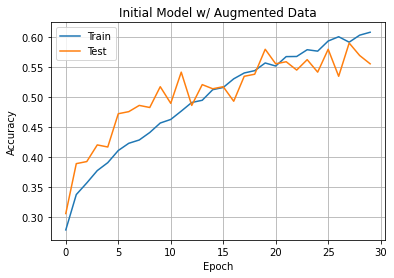

In [47]:
plot_accuracy(model_1_hist, "Initial Model w/ Augmented Data")

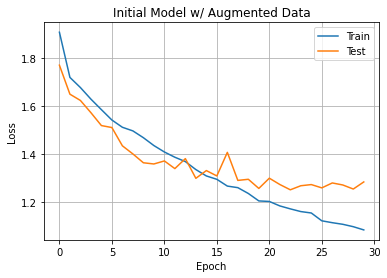

In [48]:
plot_loss(model_1_hist, "Initial Model w/ Augmented Data")

In [49]:
print("Elapsed Training Time: {} seconds".format(end_time_model_1 - start_time_model_1), "\n")

Elapsed Training Time: 282.9755630493164 seconds 



In [50]:
model_1.evaluate(X_test, y_test)

288/288 [==============================] - 0s 185us/sample - loss: 1.2844 - acc: 0.5556


[1.284419510099623, 0.5555556]

In [51]:
y_pred_model_1 = get_predictions(X_test, model_1, encoder)

In [52]:
y_labels = get_labels(y_test, encoder)

In [53]:
get_report(y_labels, y_pred_model_1, encoder)

              precision    recall  f1-score   support

       Angry       0.61      0.63      0.62        35
        Calm       0.64      0.75      0.69        36
     Disgust       0.62      0.74      0.67        39
        Fear       0.53      0.47      0.50        40
       Happy       0.41      0.31      0.35        36
     Neutral       0.57      0.50      0.53        24
         Sad       0.42      0.55      0.48        38
    Surprise       0.66      0.47      0.55        40

    accuracy                           0.56       288
   macro avg       0.56      0.55      0.55       288
weighted avg       0.56      0.56      0.55       288



### This offers a seven percent increase in accuracy over the same model with unaugmented data

## Different CNN Architecture
---

In [63]:
model_2 = tf.keras.Sequential()

model_2.add(layers.Conv1D(64, kernel_size = 20, activation = "relu", input_shape = (X_train.shape[1], 1)))

model_2.add(layers.Conv1D(128, kernel_size = 20, activation = "relu", kernel_regularizer = l2(0.01), bias_regularizer = l2(0.01)))
model_2.add(layers.MaxPooling1D(pool_size = 8))
model_2.add(layers.Dropout(0.2))

model_2.add(layers.Conv1D(128, kernel_size = 20, activation = "relu"))
model_2.add(layers.MaxPooling1D(pool_size = 8))
model_2.add(layers.Dropout(0.2))

model_2.add(layers.Flatten())
model_2.add(layers.Dense(256, activation = "relu"))
model_2.add(layers.Dropout(0.2))
model_2.add(layers.Dense(8, activation = "softmax"))

model_2.compile(loss = "categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
model_2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 240, 64)           1344      
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 221, 128)          163968    
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 27, 128)           0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 27, 128)           0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 8, 128)            327808    
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 1, 128)            0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 1, 128)           

In [64]:
start_time_model_2 = time.time()

model_2_hist = model_2.fit(X_train, y_train, batch_size = 32, epochs = 30, validation_data = (X_test, y_test))

end_time_model_2 = time.time()

Train on 9216 samples, validate on 288 samples
Epoch 1/30
9216/9216 [==============================] - 13s 1ms/sample - loss: 1.8334 - acc: 0.3088 - val_loss: 1.6538 - val_acc: 0.3438
Epoch 2/30
9216/9216 [==============================] - 11s 1ms/sample - loss: 1.6367 - acc: 0.3685 - val_loss: 1.5617 - val_acc: 0.4062
Epoch 3/30
9216/9216 [==============================] - 11s 1ms/sample - loss: 1.5598 - acc: 0.4019 - val_loss: 1.4905 - val_acc: 0.4340
Epoch 4/30
9216/9216 [==============================] - 11s 1ms/sample - loss: 1.5058 - acc: 0.4248 - val_loss: 1.4458 - val_acc: 0.4514
Epoch 5/30
9216/9216 [==============================] - 11s 1ms/sample - loss: 1.4637 - acc: 0.4345 - val_loss: 1.3856 - val_acc: 0.4757
Epoch 6/30
9216/9216 [==============================] - 12s 1ms/sample - loss: 1.4340 - acc: 0.4513 - val_loss: 1.3711 - val_acc: 0.4861
Epoch 7/30
9216/9216 [==============================] - 13s 1ms/sample - loss: 1.4007 - acc: 0.4655 - val_loss: 1.3920 - val_acc: 0

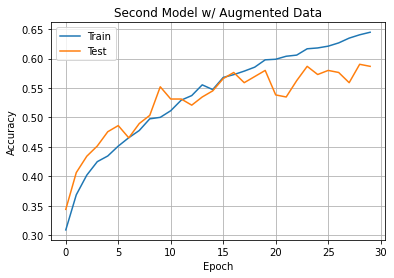

In [65]:
plot_accuracy(model_2_hist, "Second Model w/ Augmented Data")

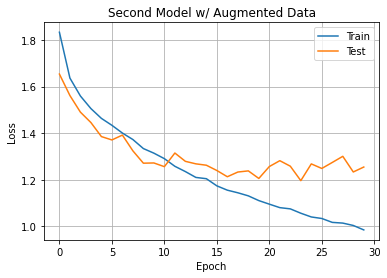

In [66]:
plot_loss(model_2_hist, "Second Model w/ Augmented Data")

In [67]:
print("Elapsed Training Time: {} seconds".format(end_time_model_2 - start_time_model_2), "\n")

Elapsed Training Time: 367.79894614219666 seconds 



In [68]:
model_2.evaluate(X_test, y_test)

288/288 [==============================] - 0s 331us/sample - loss: 1.2549 - acc: 0.5868


[1.254865778817071, 0.5868056]

In [69]:
y_pred_model_2 = get_predictions(X_test, model_2, encoder)

In [70]:
y_labels = get_labels(y_test, encoder)

In [71]:
get_report(y_labels, y_pred_model_2, encoder)

              precision    recall  f1-score   support

       Angry       0.52      0.74      0.61        35
        Calm       0.65      0.78      0.71        36
     Disgust       0.81      0.74      0.77        39
        Fear       0.59      0.50      0.54        40
       Happy       0.39      0.39      0.39        36
     Neutral       0.62      0.62      0.62        24
         Sad       0.52      0.39      0.45        38
    Surprise       0.61      0.55      0.58        40

    accuracy                           0.59       288
   macro avg       0.59      0.59      0.58       288
weighted avg       0.59      0.59      0.58       288



### This offers a ten percent increase in accuracy over the original model with unaugmented data and
### a three percent increase in accuracy over the original model using augmented data